# Lab 4 Introduction to Function Generator Usage and Reactive Components

This jupyter notebook intends to simulate the circuits used in the lab to produce the expected lab results. Circuit component measurements are used to recreate the components used in the lab.

**IMPORTANT:** Circuit simulations are done through [`Ngspice`](https://ngspice.sourceforge.io/), and the results are interpreted through the scripts written in this notebook. If you wish to run this notebook on your own, you will need to [download and install](https://ngspice.sourceforge.io/download.html) `Ngspice` for the command line. This notebook also has the following dependencies:

- `numpy`,
- `pandas`,
- `matplotlib`, and
- `tabulate`.

Run this notebook by executing each code block sequentially, or simply click "Run All" if that option is available.

**NOTE:** The experiments below originally corresponded to the lab 4 document from February 26th, 2024, which has changed since then. I have since added the adjustments to Experiment 4 to represent the new adjustments.

## Environment setup

This notebook will use the current working directory (CWD) to save data outputted by the simulations. To reduce the number of required accompanying files, the circuit files are saved as strings under each lab experiment section. This requires some auxiliary functions shown below:

In [33]:
## File Handling and Ngspice Execution
import subprocess as sp
from pathlib import Path

def tmp_file(contents, filename='tmp.cir', overwrite=True):
    """Save contents to a temporary file."""
    file_path = Path.cwd() / filename
    mode = 'w' if file_path.is_file() and overwrite else 'x'
    
    with open(filename, mode) as file:
        file.write(contents)
        file.close()
    return filename

def run_ngspice(file, capture=False):
    """Execute Ngspice with a file."""
    sp.run(f"ngspice {file}".split(),
                   stdout=sp.PIPE if capture else sp.DEVNULL,
                   stderr=sp.PIPE if capture else sp.DEVNULL)

## Experiment 2: Capacitor/Frequency Relationship

Experiment 2 uses an RC circuit described with the file below. As mentioned in the beginning, some circuit components are using the measurements of the in-lab components.

In [34]:
exp2_wave_file = 'exp2_wave.txt'
exp2_attr_file = 'exp2_attr.txt'

exp2_spice_file = (
    'Lab4e2\n'
    '\n'
    'VIN in 0 dc 0 ac 1 SIN(0 2.5 15K)\n'
    'R1 in out 98.25\n'
    'C1 out 0 98.6NF\n'
    '\n'
    '.control\n'
    'tran 1u 100u\n'
    f'wrdata {exp2_wave_file} vr(in) vr(out)\n'
    'ac dec 20 0.1KHZ 500KHZ\n'
    f'wrdata {exp2_attr_file} vm(out) ph(out)\n'
    '.endc\n'
    '.end\n'
)
print(exp2_spice_file)

Lab4e2

VIN in 0 dc 0 ac 1 SIN(0 2.5 15K)
R1 in out 98.25
C1 out 0 98.6NF

.control
tran 1u 100u
wrdata exp2_wave.txt vr(in) vr(out)
ac dec 20 0.1KHZ 500KHZ
wrdata exp2_attr.txt vm(out) ph(out)
.endc
.end



We first execute the circuit file with `Ngspice`. The results are saved in text files with values separated by spaces which we save into a DataFrame.

In [35]:
import pandas as pd

run_ngspice(tmp_file(exp2_spice_file))

exp2_wave = pd.read_csv(exp2_wave_file, sep=r'\s+', header=None)
exp2_attr = pd.read_csv(exp2_attr_file, sep=r'\s+', header=None)

Next, the data needs to be processed. The real-component voltage from the AC analysis is normalized to the source amplitude, while the phase is measured in radians. Additionally, the lab report calls for measurements at specific frequencies. We need to extract those frequencies from our data.

In [36]:
import numpy as np

def find_nearest(array, value):
    # https://stackoverflow.com/a/2566508
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

## Preprocessing the AC attributes data
# Convert data to proper units
frequency2 = exp2_attr[0]
voltage2 = exp2_attr[1] * 5
phase2 = exp2_attr[3] * -180 / np.pi

time2 = exp2_wave[0]
channel12 = exp2_wave[1]
channel22 = exp2_wave[3]

# Collect data at desired frequencies
select_frequency2 = np.array([0.1, 1, 5, 10, 15,
                              20, 25, 50, 100, 500]) * 1e3
select_phase2 = []
select_voltage2 = []

for f in select_frequency2:
    i, _ = find_nearest(frequency2, f)
    select_voltage2.append(voltage2[i])
    select_phase2.append(phase2[i])

select_phase2 = np.array(select_phase2)
select_voltage2 = np.array(select_voltage2)

Finally, the data is ready to be presented and visualized:

  frequency    voltage      phase
-----------  ---------  ---------
        100   4.99991    0.348744
       1000   4.99076    3.48318
       5000   4.78242   16.965
      10000   4.27102   31.3281
      15000   3.59849   43.9705
      20000   3.17824   50.532
      25000   2.73684   56.8133
      50000   1.55746   71.8508
     100000   0.810583  80.6702
     500000   0.183775  87.8936


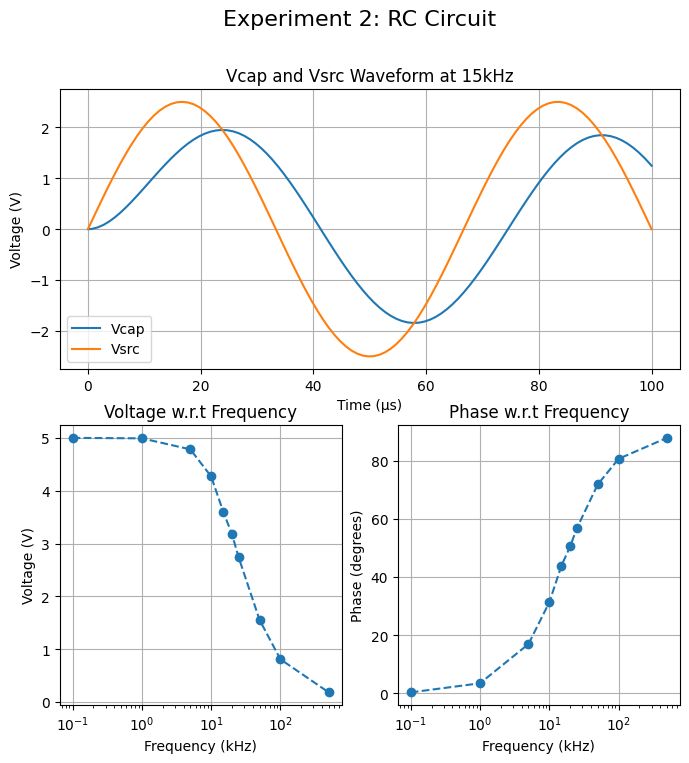

In [37]:
import matplotlib.pyplot as plt
from tabulate import tabulate

table = np.array((select_frequency2, select_voltage2, select_phase2)).T
print(tabulate(table, headers=('frequency', 'voltage', 'phase')))

fig = plt.figure(figsize=(8, 8))
fig.suptitle("Experiment 2: RC Circuit", fontsize=16)

ax0 = fig.add_subplot(2, 2, (1, 2))
ax0.plot(time2*1e6, channel22, label='Vcap')
ax0.plot(time2*1e6, channel12, label='Vsrc')
ax0.set_title("Vcap and Vsrc Waveform at 15kHz")
ax0.set_xlabel("Time (\u03bcs)")
ax0.set_ylabel("Voltage (V)")
ax0.legend()
ax0.grid(True)

ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(select_frequency2 / 1e3, select_voltage2, '--o')
ax2.set_xscale('log')
ax2.set_title("Voltage w.r.t Frequency")
ax2.set_xlabel("Frequency (kHz)")
ax2.set_ylabel("Voltage (V)")
ax2.grid(True)

ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(select_frequency2 / 1e3, select_phase2, '--o')
ax3.set_xscale('log')
ax3.set_title("Phase w.r.t Frequency")
ax3.set_xlabel("Frequency (kHz)")
ax3.set_ylabel("Phase (degrees)")
ax3.grid(True)

plt.show()

Note that these figures are visualizations of a simulation, and that the waveform has non-steady state behaviour near $t = 0$.

## Experiment 3: Inductor/Frequency Relationship

This experiment works the exact same way as the previous experiment. This experiment was removed in later revisions of Lab 4.

In [38]:
# Experiment 3

# Ngspice simulation
exp3_wave_file = 'exp3_wave.txt'
exp3_attr_file = 'exp3_attr.txt'

exp3_spice_file = (
    'Lab4e3\n'
    '\n'
    'VIN in 0 dc 0 ac 1 SIN(0 2.5 5K)\n'
    'R1 in out 98.25\n'
    'L1 out 0 100UH\n'
    '\n'
    '.control\n'
    'tran 3u 300u\n'
    f'wrdata {exp3_wave_file} vr(in) vr(out)\n'
    'ac dec 20 0.1KHZ 100KHZ\n'
    f'wrdata {exp3_attr_file} vm(out) ph(out)\n'
    '.endc\n'
    '.end'
)

print(exp3_spice_file)

Lab4e3

VIN in 0 dc 0 ac 1 SIN(0 2.5 5K)
R1 in out 98.25
L1 out 0 100UH

.control
tran 3u 300u
wrdata exp3_wave.txt vr(in) vr(out)
ac dec 20 0.1KHZ 100KHZ
wrdata exp3_attr.txt vm(out) ph(out)
.endc
.end


  frequency     voltage     phase
-----------  ----------  --------
        100  0.00319755  -89.9634
       1000  0.0319748   -89.6336
       5000  0.160175    -88.1642
      10000  0.319103    -86.3409
      15000  0.504194    -84.2125
      20000  0.632864    -82.7284
      25000  0.793022    -80.8741
      50000  1.5261      -72.2286
     100000  2.6938      -57.4007


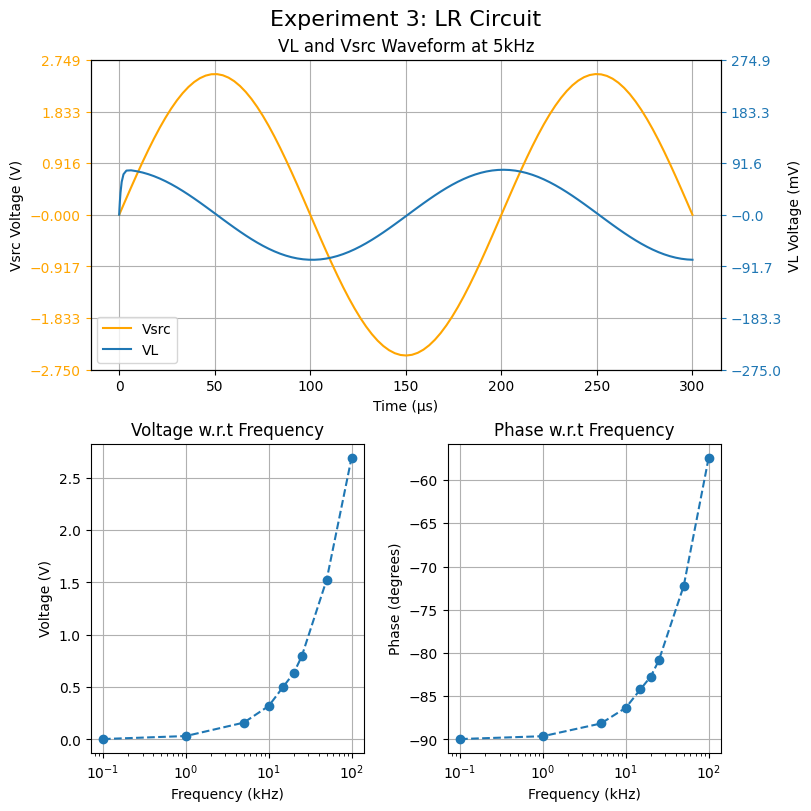

In [39]:

run_ngspice(tmp_file(exp3_spice_file))

exp3_wave = pd.read_csv(exp3_wave_file, sep=r'\s+', header=None)
exp3_attr = pd.read_csv(exp3_attr_file, sep=r'\s+', header=None)

# Data processing
frequency3 = exp3_attr[0]
voltage3 = exp3_attr[1] * 5
phase3 = exp3_attr[3] * -180 / np.pi

time3 = exp3_wave[0]
channel13 = exp3_wave[1]
channel23 = exp3_wave[3]

# Collect data at desired frequencies
select_frequency3 = np.array([0.1, 1, 5, 10, 15, 20, 25, 50, 100]) * 1e3
select_phase3 = []
select_voltage3 = []

for f in select_frequency3:
    i, _ = find_nearest(frequency3, f)
    select_voltage3.append(voltage3[i])
    select_phase3.append(phase3[i])

select_phase3 = np.array(select_phase3)
select_voltage3 = np.array(select_voltage3)

# Displaying results
table = np.array((select_frequency3, select_voltage3, select_phase3)).T
print(tabulate(table, headers=('frequency', 'voltage', 'phase')))

fig = plt.figure(layout='constrained', figsize=(8, 8))
fig.suptitle("Experiment 3: LR Circuit", fontsize=16)
ticks = np.linspace(1.1*np.min(channel13), 1.1*np.max(channel13), 7)

ax0 = fig.add_subplot(2, 2, (1, 2))
line1 = ax0.plot(time3*1e6, channel13, color='orange', label='Vsrc')
ax0.set_yticks(ticks)
ax0.tick_params('y', colors='orange')
ax0.set_title("VL and Vsrc Waveform at 5kHz")
ax0.set_xlabel("Time (\u03bcs)")
ax0.set_ylabel("Vsrc Voltage (V)")

# Channel 2 does not plot well with Channel 1,
# so it will be plotted on separate axes.
ax1 = ax0.twinx()
line2 = ax1.plot(time3*1e6, channel23*1e3, label='VL')
ax1.set_yticks(ticks*100)
ax1.tick_params('y', colors='tab:blue')
ax1.set_ylabel("VL Voltage (mV)")

ax0.grid(True)

# https://stackoverflow.com/a/5487005
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax0.legend(lines, labels, loc=0)

ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(select_frequency3 / 1e3, select_voltage3, '--o')
ax2.set_xscale('log')
ax2.set_title("Voltage w.r.t Frequency")
ax2.set_xlabel("Frequency (kHz)")
ax2.set_ylabel("Voltage (V)")
ax2.grid(True)

ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(select_frequency3 / 1e3, select_phase3, '--o')
ax3.set_xscale('log')
ax3.set_title("Phase w.r.t Frequency")
ax3.set_xlabel("Frequency (kHz)")
ax3.set_ylabel("Phase (degrees)")
ax3.grid(True)

plt.show()

## Experiment 4: RLC Circuit

This experiments places the capacitor and inductor in parallel, otherwise known as a **parallel resonance** circuit. More specifically, a circuit with a capacitor and inductor in parallel will produce a parallel resonance at a specific frequency, allowing for energy to effectively bounce between the two components. This effect is characterized AC current generated by the parallel components sharing the same phasor (amplitude and phase) as the power source.

In the earlier revision, the lab oddly requires a capacitor (22nF) that is not initially available with the given lab kit. Even more strangely, such a circuit with a 22nF capacitor would not demonstrate prallel resonance at the defined experiment frequencies within the circuit, and the use of a 10k&#x03a9; resistor does not allow the two other elements to have an affect on each other. For this simulation, the old configuration of the experiment uses a 22&#x03bc;F capacitor and 100&#x03a9; instead.

The newer revision of the lab changes the frequency range of the experiment to encompass the resonant frequency in the results with a 22nF capacitor and 100&#x03a9;.

The process of simulating to visualizing the experiment is identical to the previous experiments.

In [63]:
# Experiment 4

# The `old` flag indicates whether the simulation pertains to the old
# Lab 4 version or the newer version.
old = False

ac = 'ac lin 500 0.5KHZ 6.5KHZ' if old else 'ac dec 30 0.1KHZ 500KHZ'
transient = 'tran 3u 5000.6ms 5s' if old else 'tran 300ns 30us'
C1 = '22uF' if old else '22nF'
frequency = '3.4KHZ' if old else '105KHZ'

exp4_wave_file = 'exp4_wave.txt'
exp4_attr_file = 'exp4_attr.txt'

exp4_spice_file = (
    'Lab4e4\n'
    '\n'
    f'VIN in 0 dc 0 ac 1 SIN(0 2.5 {frequency})\n'
    'R1 in out 98.25\n'
    f'C1 out 0 {C1}\n'
    'L1 out 0 100UH\n'
    '\n'
    '.control\n'
    f'{transient}\n'
    f'wrdata {exp4_wave_file} vr(in) vr(out)\n'
    f'{ac}\n'
    f'wrdata {exp4_attr_file} vm(out) ph(out)\n'
    '.endc\n'
    '.end'
)

print(exp4_spice_file)


Lab4e4

VIN in 0 dc 0 ac 1 SIN(0 2.5 105KHZ)
R1 in out 98.25
C1 out 0 22nF
L1 out 0 100UH

.control
tran 300ns 30us
wrdata exp4_wave.txt vr(in) vr(out)
ac dec 30 0.1KHZ 500KHZ
wrdata exp4_attr.txt vm(out) ph(out)
.endc
.end


  frequency     voltage      phase
-----------  ----------  ---------
        100  0.00319755  -89.9634
       1000  0.0319776   -89.6336
       5000  0.160525    -88.1602
      10000  0.321887    -86.3089
      25000  0.837743    -80.3547
      50000  1.89657     -67.7088
      75000  3.31928     -48.4053
      85000  4.17632     -33.3566
      95000  4.59223     -23.3001
     105000  4.99916       1.04751
     115000  4.85943      13.6183
     125000  4.52917      25.0641
     135000  4.10418      34.8315
     150000  3.66483      42.8644
     200000  2.30393      62.5622
     250000  1.68761      70.274
     500000  0.82643      80.4861


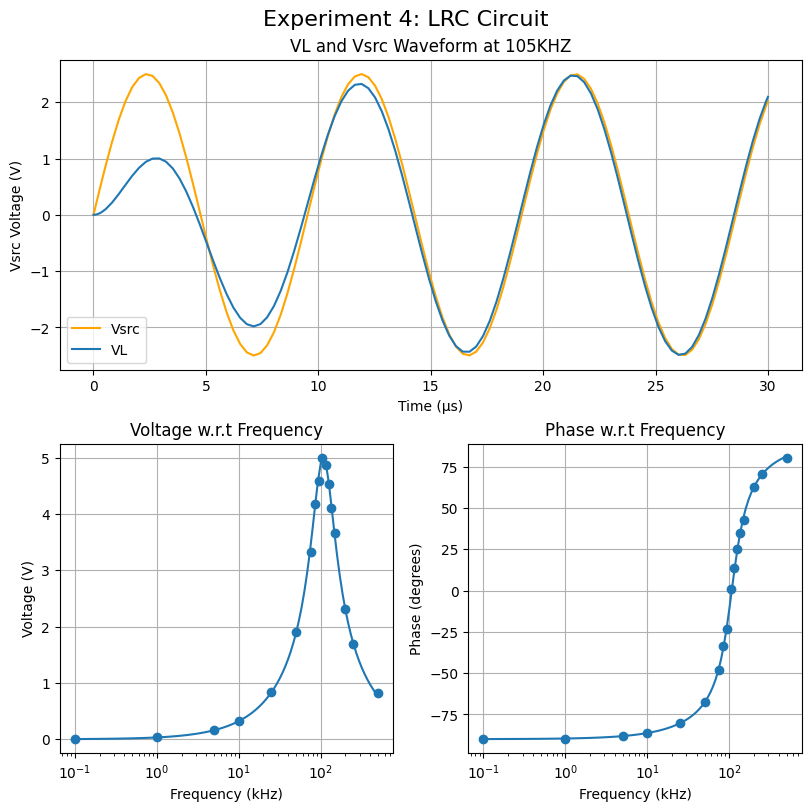

In [64]:

run_ngspice(tmp_file(exp4_spice_file))

exp4_wave = pd.read_csv(exp4_wave_file, sep=r'\s+', header=None)
exp4_attr = pd.read_csv(exp4_attr_file, sep=r'\s+', header=None)

# Data processing
frequency4 = exp4_attr[0]
voltage4 = exp4_attr[1] * 5
phase4 = exp4_attr[3] * -180 / np.pi

time4 = exp4_wave[0]
channel14 = exp4_wave[1]
channel24 = exp4_wave[3]

# Collect data at desired frequencies
if old:
    select_frequency4 = np.array([
        0.5, 1.0, 1.5, 2.0,
        3.0, 3.1, 3.2, 3.4,
        3.6, 3.8, 4.0, 4.5,
        5.0, 5.5, 6.0, 6.5
    ]) * 1e3
else:
    select_frequency4 = np.array([
        0.1, 1, 5, 10, 25, 50, 75, 85, 95,
        105, 115, 125, 135, 150, 200, 250, 500
    ]) * 1e3
select_phase4 = []
select_voltage4 = []

for f in select_frequency4:
    i, _ = find_nearest(frequency4, f)
    select_voltage4.append(voltage4[i])
    select_phase4.append(phase4[i])

select_phase4 = np.array(select_phase4)
select_voltage4 = np.array(select_voltage4)

# Displaying results
table = np.array((select_frequency4, select_voltage4, select_phase4)).T
print(tabulate(table, headers=('frequency', 'voltage', 'phase')))

fig = plt.figure(layout='constrained', figsize=(8, 8))
fig.suptitle("Experiment 4: LRC Circuit", fontsize=16)

ax0 = fig.add_subplot(2, 2, (1, 2))
ax0.plot(time4*1e6, channel14, color='orange', label='Vsrc')
ax0.plot(time4*1e6, channel24, color='tab:blue', label='VL')
ax0.set_title(f"VL and Vsrc Waveform at {frequency}")
ax0.set_xlabel("Time (\u03bcs)")
ax0.set_ylabel("Vsrc Voltage (V)")
ax0.grid(True)
ax0.legend()

ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(select_frequency4 / 1e3, select_voltage4, 'o')
ax2.plot(frequency4 / 1e3, voltage4, '-', color='tab:blue')
if not old:
    ax2.set_xscale('log')
ax2.set_title("Voltage w.r.t Frequency")
ax2.set_xlabel("Frequency (kHz)")
ax2.set_ylabel("Voltage (V)")
ax2.grid(True)

ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(select_frequency4 / 1e3, select_phase4, 'o')
ax3.plot(frequency4 / 1e3, phase4, '-', color='tab:blue')
if not old:
    ax3.set_xscale('log')
ax3.set_title("Phase w.r.t Frequency")
ax3.set_xlabel("Frequency (kHz)")
ax3.set_ylabel("Phase (degrees)")
ax3.grid(True)

plt.show()